In [202]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [203]:
falls_path = Path("WEDA-FALL/dataset/fall_timestamps.csv")
falls_df = pd.read_csv(falls_path)
falls_df.head()

,filename,start_time,end_time
0,F01/U01_R01,4.7,7.7
1,F01/U01_R02,4.7,7.7
2,F01/U01_R03,5.0,8.0
3,F02/U01_R01,5.1,8.1
4,F02/U01_R02,5.7,8.7


In [204]:
dataset = Path("WEDA-FALL/dataset/50Hz")

In [205]:
# Filter out files that contain "vertical" in their name
list(dataset.glob("F*/*_accel.csv"))

p_accel = (f for f in dataset.glob("F*/*_accel.csv") if "vertical" not in f.name)
p_gyro  = dataset.glob("F*/*_gyro.csv")

# all_files = [f for f in list(p_accel) + list(p_gyro) if "vertical" not in f.name]

In [206]:
# all_files

In [207]:
df_list = []
for acc, gyro in zip(p_accel, p_gyro):
    df1 = pd.read_csv(acc)
    df2 = pd.read_csv(gyro)
    df = pd.concat([df1, df2], axis=1)
    df_list.append(df)  
df = pd.concat(df_list, axis=0)

In [208]:
df["acceleration"] = np.sqrt(df["accel_x_list"]**2 + df["accel_y_list"]**2 + df["accel_z_list"]**2)
df["rotationrate"] = np.sqrt(df["gyro_x_list"]**2 + df["gyro_y_list"]**2 + df["gyro_z_list"]**2)
df = df.filter(items=['accel_time_list','gyro_time_list', 'acceleration', 'rotationrate'])
df

,accel_time_list,gyro_time_list,acceleration,rotationrate
0,0.000,0.000,9.365362,0.424264
1,0.001,0.002,9.906059,0.412311
2,0.003,0.004,10.014989,0.223607
3,0.005,0.005,10.439828,0.300000
4,0.121,0.127,9.442457,0.316228
...,...,...,...,...
687,13.902,13.898,9.714422,0.000000
688,13.903,13.900,9.776502,0.100000
689,13.905,13.901,10.381715,1.720465
690,13.907,13.903,10.858177,1.526434


In [209]:
split = acc.stem.split("_")
filename = str(acc.parent.name + "/" + split[0] + "_" + split[1])
falls_df[falls_df["filename"] == filename]

,filename,start_time,end_time
349,F08/U14_R04,4.0,7.5


In [210]:
_,start,end = falls_df[falls_df["filename"] == filename].iloc[0]

In [211]:
start,end

(np.float64(4.0), np.float64(7.5))

In [212]:
df["label"] = np.where(
    (df["accel_time_list"] > start) &
    (df["accel_time_list"] < end) &
    (df["gyro_time_list"] > start) &
    (df["gyro_time_list"] < end),
    "fall",
    "ADL"
)


In [213]:
X = df[['acceleration', "rotationrate"]]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [214]:
clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


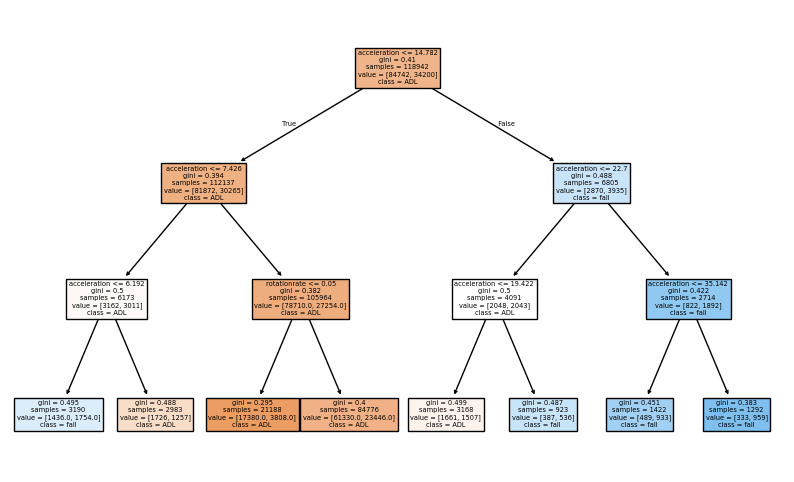

In [215]:
plt.figure(figsize=(10, 6))
plot_tree(clf, feature_names=X.columns, class_names=y.unique(), filled=True)
plt.show()

In [216]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.7277346202134338


In [217]:
import pandas as pd
from sklearn.tree import _tree

def tree_to_rules(clf, feature_names):
    tree_ = clf.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # left child
            recurse(tree_.children_left[node],
                    path + [(name, "<=", threshold)])
            # right child
            recurse(tree_.children_right[node],
                    path + [(name, ">", threshold)])
        else:
            # leaf node
            value = tree_.value[node]
            class_id = value.argmax()
            paths.append((path, class_id))

    recurse(0, [])
    return paths

# Extract rules
rules = tree_to_rules(clf, X.columns)

# Convert rules to readable intervals
for conditions, class_id in rules:
    print("Class", class_id, ":", conditions)


Class 1 : [('acceleration', '<=', np.float64(14.78157663345337)), ('acceleration', '<=', np.float64(7.425968170166016)), ('acceleration', '<=', np.float64(6.192333936691284))]
Class 0 : [('acceleration', '<=', np.float64(14.78157663345337)), ('acceleration', '<=', np.float64(7.425968170166016)), ('acceleration', '>', np.float64(6.192333936691284))]
Class 0 : [('acceleration', '<=', np.float64(14.78157663345337)), ('acceleration', '>', np.float64(7.425968170166016)), ('rotationrate', '<=', np.float64(0.05000000074505806))]
Class 0 : [('acceleration', '<=', np.float64(14.78157663345337)), ('acceleration', '>', np.float64(7.425968170166016)), ('rotationrate', '>', np.float64(0.05000000074505806))]
Class 0 : [('acceleration', '>', np.float64(14.78157663345337)), ('acceleration', '<=', np.float64(22.699560165405273)), ('acceleration', '<=', np.float64(19.421637535095215))]
Class 1 : [('acceleration', '>', np.float64(14.78157663345337)), ('acceleration', '<=', np.float64(22.699560165405273))